# Import


In [ ]:
import pandas as pd 
import numpy as np

import tensorflow as tf
import torch
from torch import nn

import matplotlib.pyplot as plt 
import seaborn as sns
from PIL import Image
sns.set_style('darkgrid')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re 
import string
import time 
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,recall_score,precision_score,accuracy_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

from tensorflow.python.client import device_lib                        
from keras.preprocessing import sequence                 
from keras.models import Sequential                      
 

from keras import regularizers
from keras.layers import Dense, Input, Flatten ,LSTM
from keras.layers import Conv1D, MaxPooling1D,GlobalMaxPooling1D, Embedding, Dropout, Activation,AveragePooling1D,BatchNormalization,Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import transformers as ppb
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertModel, BertTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
!pip install transformers
!wget https://users.dcc.uchile.cl/~jperez/beto/uncased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/uncased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/uncased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

     |████████████████████████████████| 3.1 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 44.1 MB/s 
     |████████████████████████████████| 895 kB 47.7 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 3.3 MB 48.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
--2021-11-22 15:36:36--  https://users.dcc.uchile.cl/~jperez/beto/uncased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 200.9.99.211, 192.80.24.4
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|200.9.99.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410039235 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz’

pytorch_weights.tar 100%[===================>] 391.04M  2.44MB/s    in 1m 50s  

2021-11-22 15:38:27 (3.55 MB/s) - ‘pytorch_weights.tar.gz’ saved [410039235/41003923

# Read data

In [ ]:
# 10000 правдивых новостей 
data_true = pd.read_excel('/content/drive/MyDrive/data/data_10000.xlsx')
# 2700 фейк новостей 
data_fake = pd.read_excel('/content/drive/MyDrive/data/fake news Esp.xlsx',sheet_name='all')
data_fake_2 = pd.read_excel('/content/drive/MyDrive/data/fake_v2.xlsx')
data_fake_3 = pd.read_excel('/content/drive/MyDrive/data/янв 2021.xlsx')

In [ ]:
# Рандомно отбираем 2700 правдивых новостей для баланса классов
N = 2700
rnd_st =21
data_true = data_true.groupby(['source','media','tag'], group_keys=False).apply(lambda x: x.sample(int(np.rint(N*len(x)/len(data_true))),random_state=rnd_st)).sample(frac=1,random_state=rnd_st).reset_index(drop=True)

In [ ]:
data_true.head(3)

,date,titels,text,tag,media,source
0,2021-10-25 13:41:52,NaN,—El PSOE tiene que estar—dijo Lastra nada más...,politica,ElPais,twitter
1,24 ноя 2020 г.,NaN,El presidente electo perfila su Gabinete mien...,immigracion,ElPais,FaceBook
2,"Actualizado Jueves, 14 octubre 2021 - 01:47","Descemer Bueno, el genio detrás de los hits de...","Descemer Bueno, el genio detrás de los hits de...",politica,Elmundo,Media


In [ ]:
data_true['label'] = 1
data_fake['label'] = 0
data_fake_2['label'] = 0
data_fake_3['label'] = 0
print(data_true.shape)
print(data_fake.shape)
print(data_fake_2.shape)
print(data_fake_3.shape)

(2695, 7)
(2433, 11)
(181, 7)
(98, 11)


In [ ]:
# Добавим заголовки в начало текста
data_fake['Headlines'].fillna('',inplace=True)
data_fake['Fake statement'] = data_fake['Headlines'].astype(str) +" "+ data_fake["Fake statement"] 
data_fake_2['headline'].fillna('',inplace=True)
data_fake_2['text'] = data_fake_2['headline'].astype(str) +" "+ data_fake_2["text"] 
data_fake_3['Headlines'].fillna('',inplace=True)
data_fake_3['Fake statement'] = data_fake_3['Headlines'].astype(str) +" "+ data_fake_3["Fake statement"] 

In [ ]:
data_fake.tail(3)

,Topic,Link source,Media,Date,author,Headlines,Fake statement,Full text,Type,Local,label
2430,Terrorismo,https://www.facebook.com/PeriodicoElFuete/phot...,Facebook,2019-11-23 00:00:00,Periódico El Fuete,,He aquí la foto más impactante que dejó la mo...,NaN,NaN,NaN,0
2431,Terrorismo,https://www.abc.es/espana/canarias/abci-reino-...,ABC,2018-07-15 00:00:00,NaN,Reino Unido advierte de ataques terroristas en...,Reino Unido advierte de ataques terroristas en...,NaN,NaN,NaN,0
2432,Terrorismo,NaN,whatsapp,NaN,NaN,,Hay peligro de un atentado inminente en Sevil...,NaN,NaN,NaN,0


In [ ]:
data_fake_2.head(3)

,category,topic,source,headline,text,link,label
0,Fake,Health,20 Minutos,Crema de semen para rejuvenecer la piel,Crema de semen para rejuvenecer la piel Crema ...,https://amp.20minutos.es/noticia/448256/0/crem...,0
1,Fake,Society,ABC Noticias,Joven coahuilense convivirá con premios Nobel.,Joven coahuilense convivirá con premios Nobel....,https://www.abcnoticias.mx/joven-coahuilense-c...,0
2,Fake,Health,ABC sociedad,La Unión Europea podría prohibir los kebabs po...,La Unión Europea podría prohibir los kebabs po...,http://www.abc.es/sociedad/abci-union-europea-...,0


In [ ]:
data_fake_3.head(3)

,Topic,Link source,Media,Date,author,Headlines,Fake statement,Full text,Type,Local,label
0,covid-19,NaN,Twitter,2021-01-02,@sandraro62,,"Hola, soy Sandra Romero, dni 37263954 Me puse...",NaN,fake account,national,0
1,covid-19,NaN,Facebook,NaT,NaN,,La Junta de Andalucía cierra perimetralmente ...,NaN,false information,national,0
2,Inmigración,NaN,Twitter,2021-01-04,NaN,,Un grupo de menas golpea y roba la moto a un ...,NaN,fake subscribe,international,0


In [ ]:
data_true.head(3)

,date,titels,text,tag,media,source,label
0,2021-10-25 13:41:52,NaN,—El PSOE tiene que estar—dijo Lastra nada más...,politica,ElPais,twitter,1
1,24 ноя 2020 г.,NaN,El presidente electo perfila su Gabinete mien...,immigracion,ElPais,FaceBook,1
2,"Actualizado Jueves, 14 octubre 2021 - 01:47","Descemer Bueno, el genio detrás de los hits de...","Descemer Bueno, el genio detrás de los hits de...",politica,Elmundo,Media,1


In [ ]:
#Склеим фейки и правдивые новости вместе
true_2600 = data_true.loc[:,['text','label']]
fake_2500 = data_fake.loc[:,['Fake statement','label']].rename({'Fake statement':'text'},axis=1)
fake_200 = data_fake_2.loc[:,['text','label']]
fake_100 = data_fake_3.loc[:,['Fake statement','label']].rename({'Fake statement':'text'},axis=1)

data = pd.concat([true_2600,fake_2500,fake_200,fake_100]).reset_index(drop=True)

In [ ]:
data.dropna(inplace=True) 
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(5374, 2)

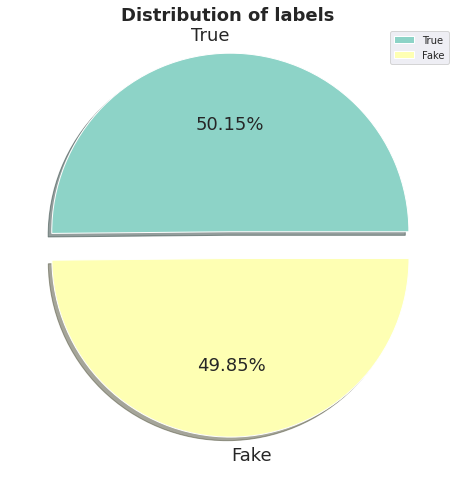

In [ ]:
counts = data['label'].value_counts()
mylabels = ["True", "Fake"]
text_font = {"fontsize":18}
explode = [0.1,0.05]
plt.figure(figsize=(8,12))
plt.pie(counts, labels = mylabels,autopct = "%0.2f%%",colors=['#8dd3c7','#feffb3'],explode = explode,textprops =text_font,shadow = True)
plt.title('Distribution of labels ',size=18,fontweight = 'bold')
plt.legend()
plt.show() 

In [ ]:
def clean_text(text):
    """The function removes punctuation marks, stop words, links, emoji,
     words with numbers inside, and converts the string to lowercase.
    Args: 
        text: input string.
    Returns:
        string.
    """
    text = str(text).lower()
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\w*\d\w*', '', text) 

    emoji_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags 
                           "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'',text)
  
    stop_word = stopwords.words('spanish') 
    
    wo_punc = [letter for letter in text if letter not in string.punctuation+str('“”—·…¡¡¡�¡⭕♦✔️◀🧵✍️«»')]
    wo_punc = ''.join(wo_punc)
    wo_stop_word = [word for word in wo_punc.split() if word not in stop_word]
    result = ' '.join(wo_stop_word)
    return result    

In [ ]:
data['clean_text'] = data['text'].apply(clean_text)

In [ ]:
#Stemming 
stemmer = PorterStemmer() #SnowballStemmer('spanish')
def stemming_text(text):
  stemmed_text = [stemmer.stem(i) for i in word_tokenize(text)]
  result = ' '.join(stemmed_text)
  return result

In [ ]:
data['stemm_text'] = data['clean_text'].apply(stemming_text)

In [ ]:
#Lemmitization
lemma = WordNetLemmatizer()
def lemma_text(text):
  lemma_text = [lemma.lemmatize(i) for i in word_tokenize(text)]
  result = ' '.join(lemma_text)
  return result

In [ ]:
data['lemm_text'] = data['clean_text'].apply(lemma_text)

In [ ]:
data.head(3)

,text,label,clean_text,stemm_text,lemm_text
0,—El PSOE tiene que estar—dijo Lastra nada más...,1,psoe estardijo lastra empezar gobierno dos si ...,psoe estardijo lastra empezar gobierno do si n...,psoe estardijo lastra empezar gobierno do si n...
1,El presidente electo perfila su Gabinete mien...,1,presidente electo perfila gabinete mientras do...,president electo perfila gabinet mientra donal...,presidente electo perfila gabinete mientras do...
2,"Descemer Bueno, el genio detrás de los hits de...",1,descemer bueno genio detrás hits enrique igles...,descem bueno genio detrá hit enriqu iglesia ay...,descemer bueno genio detrás hit enrique iglesi...


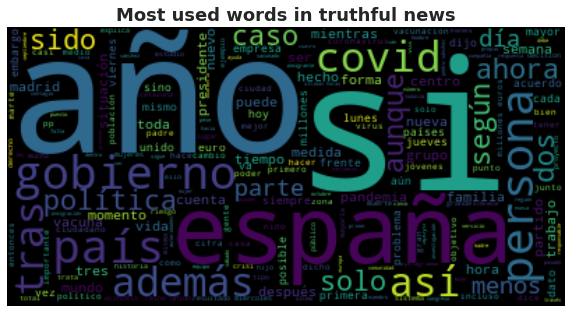

In [ ]:
wordcloud_true = WordCloud().generate(' '.join(data[data['label']==1]['clean_text']))

plt.figure(figsize=(10,15))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis("off")
plt.title('Most used words in truthful news',size=18,fontweight = 'bold')
plt.show()

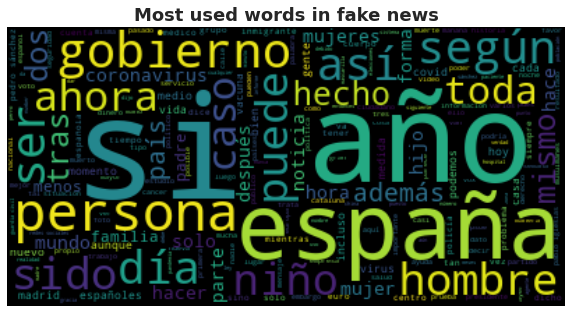

In [ ]:
wordcloud_fake = WordCloud().generate(' '.join(data[data['label']==0]['clean_text']))

plt.figure(figsize=(10,15))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Most used words in fake news',size=18,fontweight = 'bold')
plt.show()

# Train test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data.drop('label',axis=1), data['label'], test_size=0.2, random_state=rnd_st,stratify=data['label'])

In [ ]:
print('Train',X_train.shape[0])
print('Val',X_val.shape[0])

Train 4299
Val 1075


# Tf-idf ML


In [ ]:
tf = TfidfVectorizer()
tf.fit(X_train['lemm_text'])
X_train_tf = tf.transform(X_train['lemm_text'])
X_val_tf = tf.transform(X_val['lemm_text'])

In [ ]:
print(X_train_tf.shape)
print(X_val_tf.shape)

(4299, 52197)
(1075, 52197)


In [ ]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
models.append(('Tree', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))    
models.append(('ABoost', AdaBoostClassifier()))
models.append(('GBoost', GradientBoostingClassifier()))
models.append(('LogReg', LogisticRegression()))
models.append(('NaivB', MultinomialNB()))


In [ ]:
cm_list = []

print('Model\tAcc\tPr\tRecall\tF1\tTime')      

for name, alg in models:
    start_time = time.time()
    model = alg.fit(X_train_tf,y_train)
    delta = time.time() - start_time

    accuracy =accuracy_score(y_val, model.predict(X_val_tf))
    recall = recall_score(y_val, model.predict(X_val_tf))
    precision = precision_score(y_val, model.predict(X_val_tf))
    f_score = f1_score(y_val, model.predict(X_val_tf))

    cm_list.append((name, model.predict(X_val_tf)))
    
    print('{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.2f} secs'.format(name, accuracy, precision, recall, f_score, delta))

Model	Acc	Pr	Recall	F1	Time
KNN	0.785	0.764	0.827	0.794	0.01 secs
SVM	0.872	0.926	0.809	0.863	10.88 secs
Tree	0.815	0.833	0.788	0.810	2.87 secs
RF	0.848	0.873	0.816	0.844	8.00 secs
ABoost	0.840	0.888	0.779	0.830	3.41 secs
GBoost	0.838	0.905	0.757	0.824	14.64 secs
LogReg	0.860	0.904	0.805	0.852	0.53 secs
NaivB	0.763	0.684	0.978	0.805	0.01 secs


In [ ]:
def conf_matrix(cm,title=''):
    plt.figure(figsize=(10,6))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax,annot_kws={"size": 15},cmap="YlGnBu"); 
    
    ax.set_xlabel('Predicted',size=15);
    ax.set_ylabel('True',size=15); 
    ax.set_title('Confusion Matrix '+ title,size=18); 
    ax.xaxis.set_ticklabels(['fake', 'true'],size=15);
    ax.yaxis.set_ticklabels(['fake', 'true'],size=15);
    plt.show()

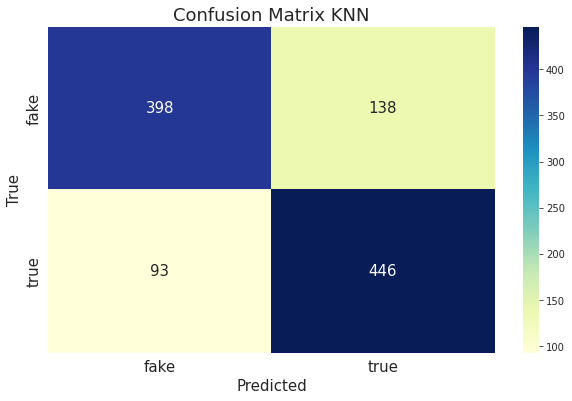

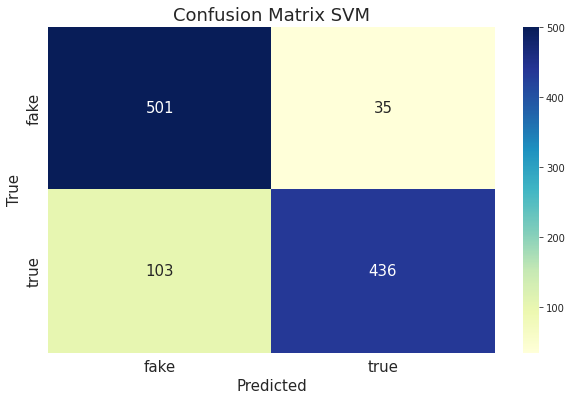

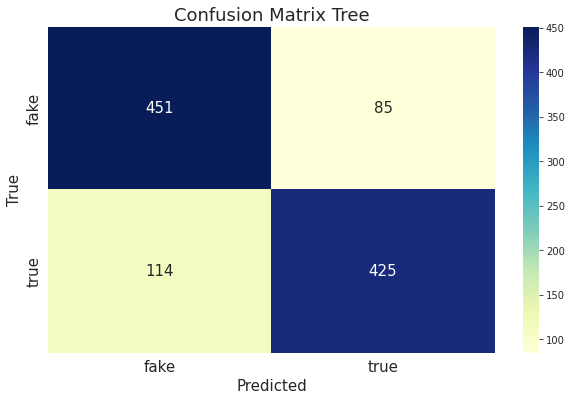

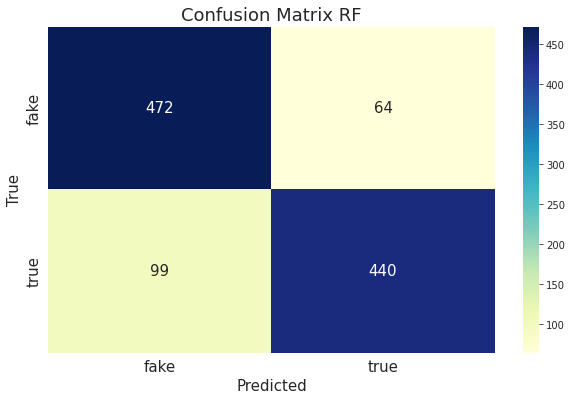

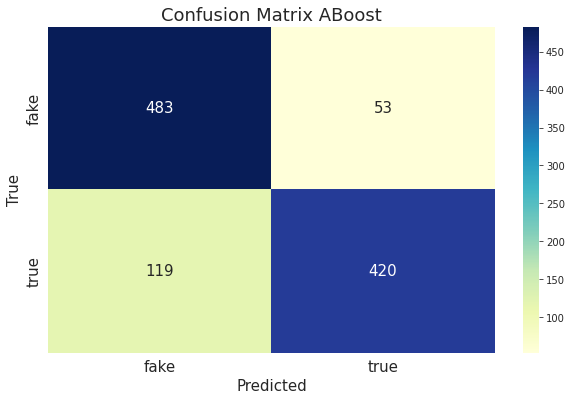

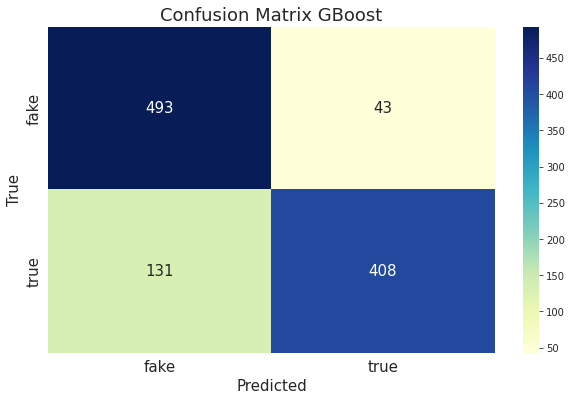

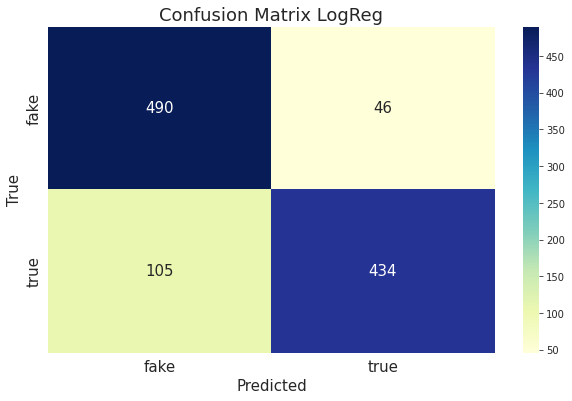

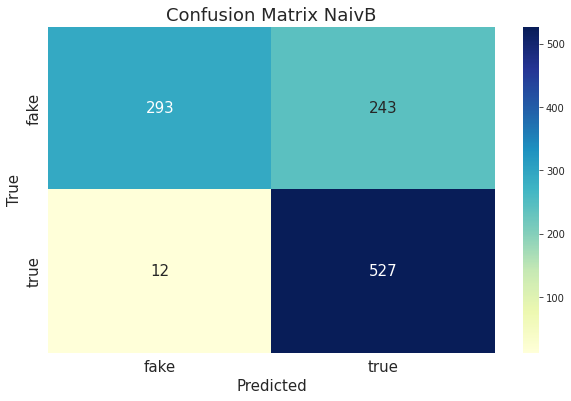

In [ ]:
for title_mdl,mdl in cm_list:
  conf_mat = confusion_matrix(y_val,mdl)
  conf_matrix(cm=conf_mat,title=str(title_mdl))
  print('\n')

In [ ]:
def error_analysis(real,predict):
  ''' This function displays news in which the model was wrong '''
  error_pred = []
  error_real = []
  error_text = []
  for pred,real,index in zip(predict,real,range(len(real))): 
    if pred != real:

      error_pred.append(pred)
      error_real.append(real)
      error_text.append(X_val.reset_index(drop=True).loc[index,'text'])
  error_df = pd.DataFrame({'text':error_text,'prediction':error_pred,'real':error_real})
  return error_df

In [ ]:
error_analysis(y_val,cm_list[1][1]).to_excel('SVM.xlsx',index=False)
error_analysis(y_val,cm_list[1][1]) #SVM errors

,text,prediction,real
0,¡VOX presenta en el Congreso en su primer mes...,1,0
1,Además de este hallazgo se han encontrado arm...,0,1
2,Pillan a un magrebí saboteando las vías del tr...,1,0
3,El director de la OMS en Europa sugiere que el...,1,0
4,Expulsan del Pleno del Congreso a un diputado...,0,1
...,...,...,...
133,"Pedro Martín-Barrajón: ""El suicidio es un prob...",0,1
134,"#Editorial 📚 ""Los cantos de sirena populistas...",0,1
135,un contenido que asegura que 53 personas han ...,1,0
136,Después del choque entre el PSOE y Unidas Pod...,0,1


# Tokenization


In [ ]:
MAX_SEQUENCE_LENGTH = 500  
min_count = 5
EMBEDDING_DIM = 300

In [ ]:
features_train = list(X_train['lemm_text'])
labels_train = np.asarray(y_train)

features_val = list(X_val['lemm_text'])
labels_val = np.asarray(y_val)


In [ ]:
token_counts = Counter()

In [ ]:
# 
for _, row in X_train[['lemm_text']].iterrows():
    for text in row:
        token_counts.update(text.split(" "))

In [ ]:
print("All tokens from train:",len(token_counts))\

All tokens from train: 52585


In [ ]:
# Берем токены которые встречаются чаще 5
min_count = 5
tokens = [token for token, count in token_counts.items() if count >= min_count]

In [ ]:
PAD, UNK = "PAD","UNK"
tokens = [PAD,UNK] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 14310


In [ ]:
#Словарь токенов
token_to_id = {token: idx for idx, token in enumerate(tokens)} 

In [ ]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float("inf"))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i, seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, : len(row_ix)] = row_ix

    return matrix

In [ ]:
# Добавляем паддинг 
data_train = as_matrix(X_train['lemm_text'].values,max_len=MAX_SEQUENCE_LENGTH)
data_val = as_matrix(X_val['lemm_text'].values,max_len=MAX_SEQUENCE_LENGTH)

In [ ]:
data_train[0:3]

array([[ 6340, 10492,  3792, ...,     0,     0,     0],
       [ 5539, 10275, 10512, ...,     0,     0,     0],
       [ 2920, 10542,     1, ...,     0,     0,     0]], dtype=int32)

In [ ]:
# Словарь word2vec
embeddings_index = {}
f = open('/content/drive/MyDrive/data/SBW-vectors-300-min5.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
del embeddings_index['1000653']

In [ ]:
#Матрица эмбеддингов
embedding_matrix =  np.random.normal(scale = 0.06,size=(len(token_to_id) + 1, EMBEDDING_DIM)) #np.random.random
cnt=0
for word, i in token_to_id.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
      cnt +=1


embedding_layer = Embedding(len(token_to_id) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [ ]:
print('Number of words not found in corpus:',cnt)

Number of words not found in corpus: 743


# CNN



In [ ]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9308429301427392722
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11320098816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6997547498134484436
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 416903419
]


In [ ]:
del model 

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(filters=128, kernel_size=10, strides=2, padding='same', activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
#l_cov2 = Conv1D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(l_pool1)
#l_pool2 = MaxPooling1D(5)(l_cov2)
#l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
#l_pool3 = MaxPooling1D(5)(l_cov3)  
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
dropout = Dropout(0.5)(l_dense)
preds = Dense(1, activation='sigmoid')(dropout)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          4293300   
                                                                 
 conv1d (Conv1D)             (None, 250, 128)          384128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 128)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 128)               819328    
                                                             

In [ ]:
history=model.fit(data_train, labels_train, validation_data=(data_val, labels_val),epochs=5, batch_size=32,callbacks=[cp])

Epoch 1/5
134/135 [============================>.] - ETA: 0s - loss: 0.5403 - acc: 0.7176
Epoch 00001: val_acc improved from -inf to 0.84000, saving model to model_cnn.hdf5
135/135 [==============================] - 35s 34ms/step - loss: 0.5396 - acc: 0.7178 - val_loss: 0.3807 - val_acc: 0.8400
Epoch 2/5
133/135 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9243
Epoch 00002: val_acc improved from 0.84000 to 0.85860, saving model to model_cnn.hdf5
135/135 [==============================] - 4s 31ms/step - loss: 0.1951 - acc: 0.9237 - val_loss: 0.3434 - val_acc: 0.8586
Epoch 3/5
133/135 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9941
Epoch 00003: val_acc improved from 0.85860 to 0.86605, saving model to model_cnn.hdf5
135/135 [==============================] - 4s 31ms/step - loss: 0.0273 - acc: 0.9942 - val_loss: 0.4995 - val_acc: 0.8660
Epoch 4/5
133/135 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9993
Epoch 00004: val_a

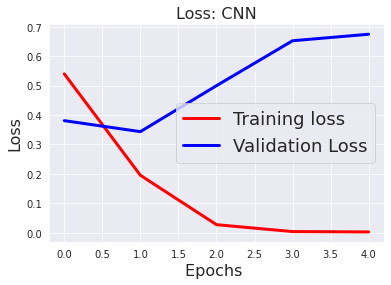

In [ ]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: CNN',fontsize=16)
plt.show()

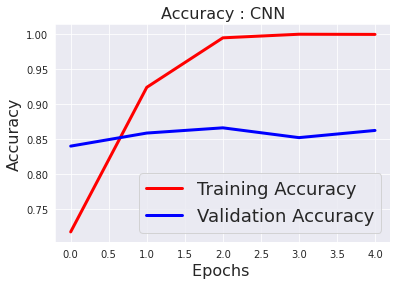

In [ ]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : CNN',fontsize=16)
plt.show()

In [ ]:
model.load_weights('model_cnn.hdf5')

In [ ]:
predict_val = np.where(model.predict(data_val).reshape(-1,) >= 0.5, 1, 0) 

In [ ]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.866046511627907
recall 0.8460111317254174
precision 0.8820116054158608
F-score 0.8636363636363636


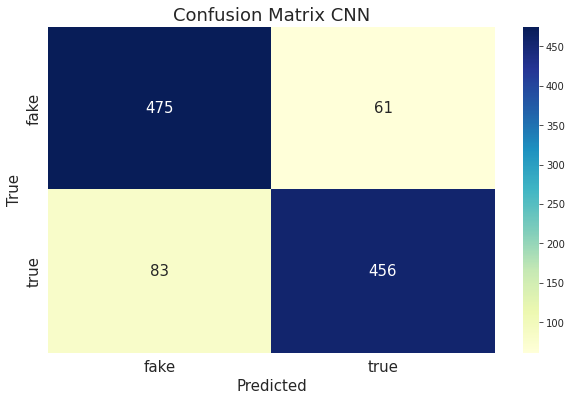

In [ ]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='CNN')

In [ ]:
error_analysis(labels_val,predict_val).to_excel('CNN.xlsx',index=False)
error_analysis(labels_val,predict_val)

,text,prediction,real
0,"Una foto del presidente del Partido Popular, ...",1,0
1,¡VOX presenta en el Congreso en su primer mes...,1,0
2,Vuelven los sonámbulos Irrealidad. La sensaci...,0,1
3,Sánchez prepara una reforma de la Constitució...,1,0
4,El evento anual de Krampus en el South Tyrol ...,1,0
...,...,...,...
139,"Pedro Martín-Barrajón: ""El suicidio es un prob...",0,1
140,Bailes sin mascarilla ni distancia de segurida...,0,1
141,Volcan Krakatoa hace erupción. Y despierta a ...,1,0
142,Ingresada una influencer madrileña por hipote...,1,0


In [ ]:
del model

# RNN

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
preds = Dense(1, activation='sigmoid')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Bidirectional LSTM
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          4293300   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              320800    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 4,614,301
Trainable params: 4,614,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(data_train, labels_train, validation_data=(data_val, labels_val),epochs=5, batch_size=32,callbacks=[cp])

Epoch 1/5
135/135 [==============================] - ETA: 0s - loss: 0.2224 - acc: 0.9218
Epoch 00001: val_acc improved from -inf to 0.68744, saving model to model_rnn.hdf5
135/135 [==============================] - 30s 187ms/step - loss: 0.2224 - acc: 0.9218 - val_loss: 1.3956 - val_acc: 0.6874
Epoch 2/5
135/135 [==============================] - ETA: 0s - loss: 0.1154 - acc: 0.9679
Epoch 00002: val_acc improved from 0.68744 to 0.84744, saving model to model_rnn.hdf5
135/135 [==============================] - 24s 178ms/step - loss: 0.1154 - acc: 0.9679 - val_loss: 0.4471 - val_acc: 0.8474
Epoch 3/5
135/135 [==============================] - ETA: 0s - loss: 0.0195 - acc: 0.9951
Epoch 00003: val_acc did not improve from 0.84744
135/135 [==============================] - 24s 176ms/step - loss: 0.0195 - acc: 0.9951 - val_loss: 0.4967 - val_acc: 0.8447
Epoch 4/5
135/135 [==============================] - ETA: 0s - loss: 0.0047 - acc: 0.9995
Epoch 00004: val_acc improved from 0.84744 to 0.8

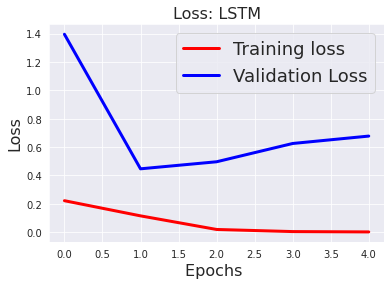

In [ ]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: LSTM',fontsize=16)
plt.show()

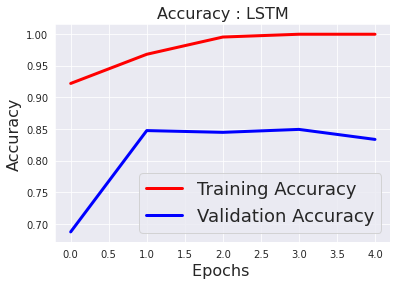

In [ ]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : LSTM',fontsize=16)
plt.show()

In [ ]:
model.load_weights('model_rnn.hdf5')
predict_val = np.where(model.predict(data_val).reshape(-1,) >= 0.5, 1, 0) 

In [ ]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.8493023255813954
recall 0.8608534322820037
precision 0.8421052631578947
F-score 0.8513761467889909


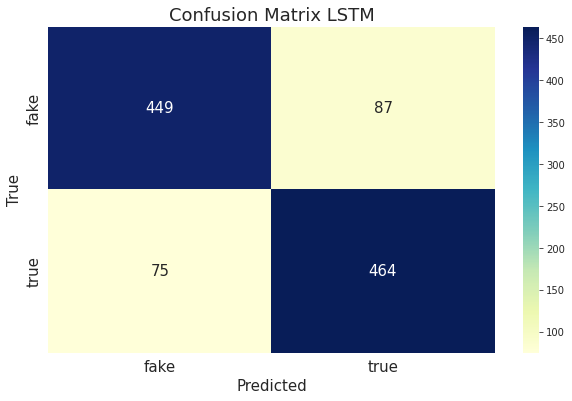

In [ ]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='LSTM')

In [ ]:
error_analysis(labels_val,predict_val).to_excel('LSTM.xlsx',index=False) 
error_analysis(labels_val,predict_val)

,text,prediction,real
0,El 95% de plástico que contamina los océanos ...,1,0
1,"Una foto del presidente del Partido Popular, ...",1,0
2,el PSOE ha denunciado al tuitero Alvise Pérez...,1,0
3,¡VOX presenta en el Congreso en su primer mes...,1,0
4,Maroto vuelve a empadronarse en Vitoria ante l...,1,0
...,...,...,...
157,El seleccionador nacional de ciclismo Pascual ...,0,1
158,El país más feliz del mundo busca desesperadam...,0,1
159,"Marbella, Málaga y prácticamente toda la Cost...",1,0
160,Se está difundiendo la captura de una supues...,1,0


In [ ]:
del model

# CNN + RNN



In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(filters=100, kernel_size=10, strides=2, padding='same', activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(10)(l_cov1)
l_lstm = Bidirectional(LSTM(50))(l_cov1)  
l_flat = Flatten()(l_lstm)
l_dense = Dense(100, activation='relu')(l_flat)
dropout = Dropout(0.5)(l_dense)
preds = Dense(1, activation='sigmoid')(dropout)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()
cp=ModelCheckpoint('model_cnn_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          4293300   
                                                                 
 conv1d_1 (Conv1D)           (None, 250, 100)          300100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                           

In [ ]:
history=model.fit(data_train, labels_train, validation_data=(data_val, labels_val),epochs=5, batch_size=32,callbacks=[cp])

Epoch 1/5
135/135 [==============================] - ETA: 0s - loss: 0.0766 - acc: 0.9819
Epoch 00001: val_acc improved from -inf to 0.82326, saving model to model_cnn_rnn.hdf5
135/135 [==============================] - 20s 121ms/step - loss: 0.0766 - acc: 0.9819 - val_loss: 0.8423 - val_acc: 0.8233
Epoch 2/5
135/135 [==============================] - ETA: 0s - loss: 0.0109 - acc: 0.9970
Epoch 00002: val_acc improved from 0.82326 to 0.84000, saving model to model_cnn_rnn.hdf5
135/135 [==============================] - 13s 100ms/step - loss: 0.0109 - acc: 0.9970 - val_loss: 0.8653 - val_acc: 0.8400
Epoch 3/5
135/135 [==============================] - ETA: 0s - loss: 0.0016 - acc: 0.9998
Epoch 00003: val_acc did not improve from 0.84000
135/135 [==============================] - 13s 99ms/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.9830 - val_acc: 0.8372
Epoch 4/5
135/135 [==============================] - ETA: 0s - loss: 3.8512e-04 - acc: 1.0000
Epoch 00004: val_acc improved from 0.8

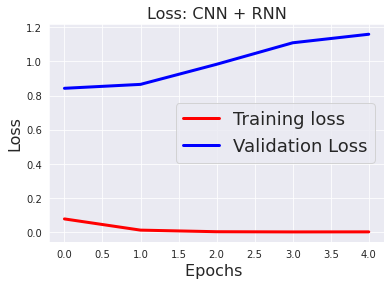

In [ ]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: CNN + RNN',fontsize=16)
plt.show()

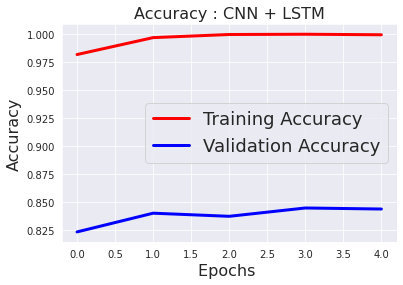

In [ ]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : CNN + LSTM',fontsize=16)
plt.show()

In [ ]:
model.load_weights('model_cnn_rnn.hdf5')
predict_val = np.where(model.predict(data_val).reshape(-1,) >= 0.5, 1, 0) 

In [ ]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.8446511627906976
recall 0.8256029684601113
precision 0.859073359073359
F-score 0.8420056764427625


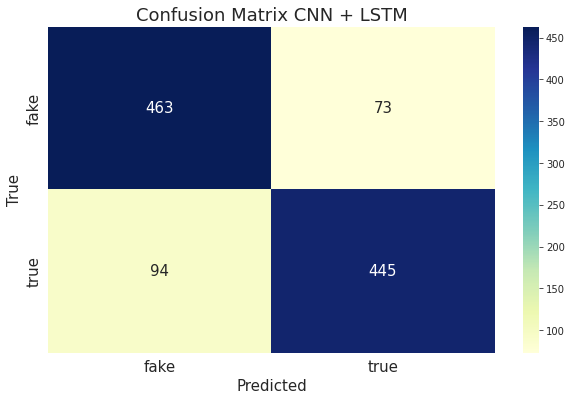

In [ ]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='CNN + LSTM')

In [ ]:
error_analysis(labels_val,predict_val).to_excel('CNN + LSTM.xlsx',index=False)
error_analysis(labels_val,predict_val)

,text,prediction,real
0,El 95% de plástico que contamina los océanos ...,1,0
1,"intentan ocultar el ""muñeco"" para que los esp...",1,0
2,¡VOX presenta en el Congreso en su primer mes...,1,0
3,Vuelven los sonámbulos Irrealidad. La sensaci...,0,1
4,Maroto vuelve a empadronarse en Vitoria ante l...,1,0
...,...,...,...
162,El seleccionador nacional de ciclismo Pascual ...,0,1
163,Máxima alerta policial para el sábado en Madri...,0,1
164,El país más feliz del mundo busca desesperadam...,0,1
165,Volcan Krakatoa hace erupción. Y despierta a ...,1,0


# BERT without training 

In [ ]:
del model

In [ ]:
# Используем BETO - Испанский предобученный BERT
tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=True)
model = BertModel.from_pretrained("pytorch/")
e = model.eval()

Some weights of the model checkpoint at pytorch/ were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenized = data['clean_text'].apply((lambda x: tokenizer.encode(x,max_length=300, add_special_tokens=True)))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
#Заполняем паддингом
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
padded.shape

(5374, 300)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(5374, 300)

In [ ]:
device = torch.device("cuda:0")
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31002, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
import tqdm

In [ ]:
output = []
batch_size = 64
for idx in tqdm.tnrange(0, 5374, batch_size):
  batch = torch.tensor(padded[idx: idx+batch_size]).to(device)
  local_attention_mask = torch.tensor(attention_mask[idx:idx+batch_size]).to(device)

  with torch.no_grad():
    last_hidden_states = model(batch, attention_mask=local_attention_mask) [0] [:,0,:].cpu().numpy()
    output.append(last_hidden_states)

  0%|          | 0/84 [00:00<?, ?it/s]

In [ ]:
feature_after_bert = np.vstack(output) # Выход с берта (эмбеддинги)

In [ ]:
labels = data['label']

In [ ]:
print(feature_after_bert.shape)
print(labels.shape)

(5374, 768)
(5374,)


In [ ]:
train_features, val_features, train_labels, val_labels = train_test_split(feature_after_bert, labels, test_size=0.2, random_state=rnd_st,stratify=labels)

In [ ]:
print('Train',train_features.shape[0])
print('Val',val_features.shape[0])

Train 4299
Val 1075


In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [ ]:
predict_val = lr_clf.predict(val_features)

In [ ]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.7851162790697674
recall 0.7810760667903525
precision 0.7883895131086143
F-score 0.7847157502329917


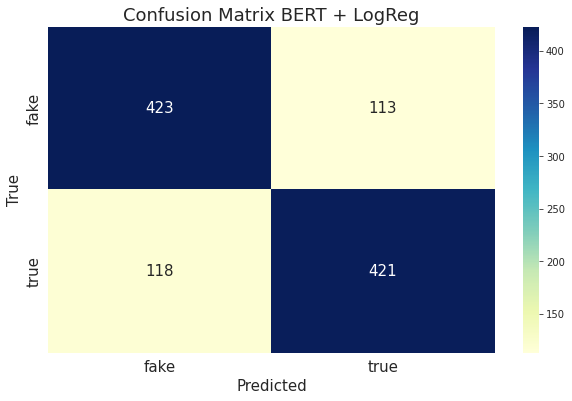

In [ ]:
conf_matrix(cm=confusion_matrix(val_labels, predict_val),title='BERT + LogReg')

In [ ]:
error_analysis(labels_val,predict_val).to_excel('BERT+LogReg.xlsx',index=False)
error_analysis(labels_val,predict_val)

,text,prediction,real
0,esta mujer de color está en la cárcel y parec...,1,0
1,El 95% de plástico que contamina los océanos ...,1,0
2,Nicolás Maduro dice los niños con enfermedade...,1,0
3,Así avanza el ritmo de vacunación del COVID p...,0,1
4,No soy partidario de la violencia pero disfru...,1,0
...,...,...,...
226,Ingresada una influencer madrileña por hipote...,1,0
227,Fechas Apertura: (Calendario tentativo)\n12 d...,1,0
228,"""Es importante tener en la cabeza que esto no...",0,1
229,…7 países africanos para frenar la inmigració...,0,1


# BERT + CNN

In [ ]:
sequence_input = Input(shape=(train_features.shape[1],1)) #Input(shape = (train_features.shape,1,)
#embedded_sequences = Embedding()(sequence_input)
l_cov1= Conv1D(filters=128, kernel_size=10, strides=2, padding='same', activation='relu')(sequence_input)
l_pool1 = MaxPooling1D(5)(l_cov1)
#l_cov2 = Conv1D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu')(l_pool1)
#l_pool2 = MaxPooling1D(5)(l_cov2)
#l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
#l_pool3 = MaxPooling1D(5)(l_cov3)  
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
dropout = Dropout(0.5)(l_dense)
preds = Dense(1, activation='sigmoid')(dropout)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()
cp=ModelCheckpoint('model_cnn_bert.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 384, 128)          1408      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 76, 128)          0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9728)              0         
                                                                 
 dense_5 (Dense)             (None, 128)               1245312   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                           

In [ ]:
history=model.fit(train_features, train_labels, validation_data=(val_features, val_labels),epochs=10, batch_size=16,callbacks=[cp]) 

Epoch 1/10
267/269 [============================>.] - ETA: 0s - loss: 0.6076 - acc: 0.6791
Epoch 00001: val_acc improved from -inf to 0.76651, saving model to model_cnn_bert.hdf5
269/269 [==============================] - 3s 8ms/step - loss: 0.6073 - acc: 0.6797 - val_loss: 0.5228 - val_acc: 0.7665
Epoch 2/10
267/269 [============================>.] - ETA: 0s - loss: 0.5226 - acc: 0.7456
Epoch 00002: val_acc improved from 0.76651 to 0.79628, saving model to model_cnn_bert.hdf5
269/269 [==============================] - 2s 8ms/step - loss: 0.5223 - acc: 0.7455 - val_loss: 0.4637 - val_acc: 0.7963
Epoch 3/10
269/269 [==============================] - ETA: 0s - loss: 0.4836 - acc: 0.7669
Epoch 00003: val_acc improved from 0.79628 to 0.80558, saving model to model_cnn_bert.hdf5
269/269 [==============================] - 2s 8ms/step - loss: 0.4836 - acc: 0.7669 - val_loss: 0.4623 - val_acc: 0.8056
Epoch 4/10
265/269 [============================>.] - ETA: 0s - loss: 0.4578 - acc: 0.7875
Epo

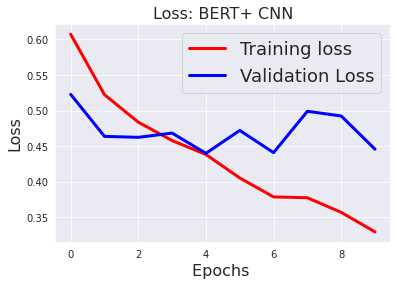

In [ ]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: BERT+ CNN',fontsize=16)
plt.show()

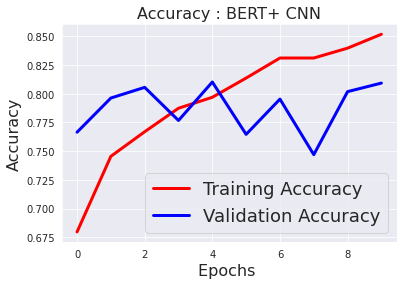

In [ ]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : BERT+ CNN',fontsize=16)
plt.show()

In [ ]:
model.load_weights('model_cnn_bert.hdf5')
predict_val = np.where(model.predict(val_features).reshape(-1,) >= 0.5, 1, 0) 

In [ ]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.8102325581395349
recall 0.8089053803339518
precision 0.8119180633147114
F-score 0.8104089219330854


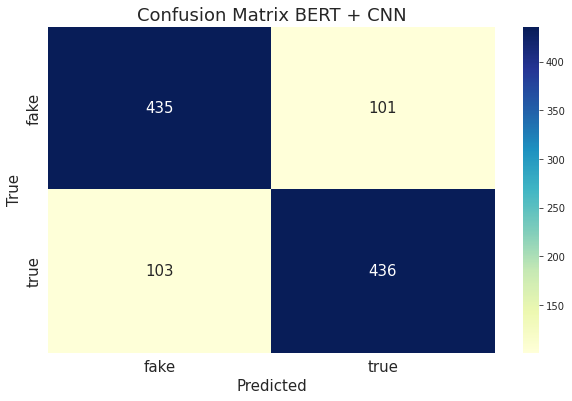

In [ ]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='BERT + CNN')

In [ ]:
error_analysis(labels_val,predict_val).to_excel('BERT+CNN.xlsx',index=False)
error_analysis(labels_val,predict_val)

,text,prediction,real
0,Así avanza el ritmo de vacunación del COVID p...,0,1
1,"Una foto del presidente del Partido Popular, ...",1,0
2,¡VOX presenta en el Congreso en su primer mes...,1,0
3,"""Fred Trump con su esposa Mary A. MacLeod ata...",1,0
4,Sánchez prepara una reforma de la Constitució...,1,0
...,...,...,...
199,Después del choque entre el PSOE y Unidas Pod...,0,1
200,Fechas Apertura: (Calendario tentativo)\n12 d...,1,0
201,Detienen a los dos valientes que pusieron el h...,1,0
202,"""Es importante tener en la cabeza que esto no...",0,1


# BERT + LSTM

In [ ]:
del model

In [ ]:
sequence_input = Input(shape=(train_features.shape[1],1)) #Input(shape = (train_features.shape,1,)

l_lstm = Bidirectional(LSTM(200))(sequence_input)
preds = Dense(1, activation='sigmoid')(l_lstm)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model.summary()
cp=ModelCheckpoint('model_rnn_bert.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Bidirectional LSTM
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 400)              323200    
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 401       
                                                                 
Total params: 323,601
Trainable params: 323,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(train_features, train_labels, validation_data=(val_features, val_labels),epochs=10, batch_size=16,callbacks=[cp])

Epoch 1/10
269/269 [==============================] - ETA: 0s - loss: 0.6513 - acc: 0.6146
Epoch 00001: val_acc improved from -inf to 0.65581, saving model to model_rnn_bert.hdf5
269/269 [==============================] - 87s 309ms/step - loss: 0.6513 - acc: 0.6146 - val_loss: 0.6157 - val_acc: 0.6558
Epoch 2/10
269/269 [==============================] - ETA: 0s - loss: 0.6210 - acc: 0.6408
Epoch 00002: val_acc improved from 0.65581 to 0.66419, saving model to model_rnn_bert.hdf5
269/269 [==============================] - 82s 304ms/step - loss: 0.6210 - acc: 0.6408 - val_loss: 0.6058 - val_acc: 0.6642
Epoch 3/10
269/269 [==============================] - ETA: 0s - loss: 0.6133 - acc: 0.6574
Epoch 00003: val_acc improved from 0.66419 to 0.67256, saving model to model_rnn_bert.hdf5
269/269 [==============================] - 82s 304ms/step - loss: 0.6133 - acc: 0.6574 - val_loss: 0.6077 - val_acc: 0.6726
Epoch 4/10
269/269 [==============================] - ETA: 0s - loss: 0.6129 - acc: 0

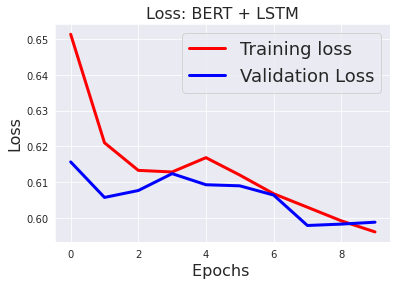

In [ ]:
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss: BERT + LSTM',fontsize=16)
plt.show()

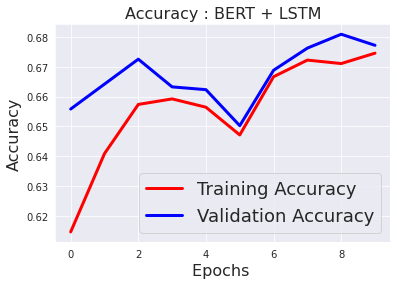

In [ ]:
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy : BERT + LSTM',fontsize=16)
plt.show()

In [ ]:
model.load_weights('model_rnn_bert.hdf5')
predict_val = np.where(model.predict(val_features).reshape(-1,) >= 0.5, 1, 0) 

In [ ]:
print('accuracy',accuracy_score(labels_val,predict_val))
print('recall',recall_score(labels_val,predict_val))
print('precision',precision_score(labels_val,predict_val))
print('F-score',f1_score(labels_val,predict_val))

accuracy 0.6809302325581396
recall 0.6307977736549165
precision 0.7024793388429752
F-score 0.6647116324535679


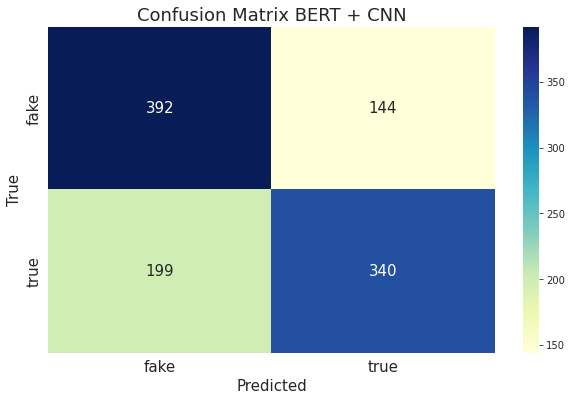

In [ ]:
conf_matrix(cm=confusion_matrix(labels_val,predict_val),title='BERT + CNN')

In [ ]:
error_analysis(labels_val,predict_val).to_excel('BERT+LSTM.xlsx',index=False)
error_analysis(labels_val,predict_val)

,text,prediction,real
0,La inmigración ha sido el mayor cambio social...,0,1
1,Asignaturas con libros más finos y menos enci...,0,1
2,"Para unos, Marc Clotet es el hijo del doctor ...",0,1
3,Indonesia es cada vez más peligroso para los h...,0,1
4,Nicolás Maduro dice los niños con enfermedade...,1,0
...,...,...,...
338,Suecia estrena jornada laboral de 6 horas sin ...,1,0
339,Después del choque entre el PSOE y Unidas Pod...,0,1
340,Fechas Apertura: (Calendario tentativo)\n12 d...,1,0
341,"""Es importante tener en la cabeza que esto no...",0,1


# BertForSequenceClassification (With training)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Сделаем TensorDataset
input_ids = torch.from_numpy(padded) #токкены с паддингом 
attention_masks = torch.from_numpy(attention_mask) # атеншен маска 
labels = torch.tensor(list(labels)) # лейблы 

dataset = TensorDataset(input_ids, attention_masks, labels)

# Делим tain test в соотношении 80/20
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Перемешиваем данные для tain и test 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,299 training samples
1,075 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset),# бачи выбираем рандомно 
            batch_size = batch_size 
        )


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # бачи выбираем последовательно 
            batch_size = batch_size 
        )

In [ ]:
model = BertForSequenceClassification.from_pretrained("pytorch/",num_labels = 2)
model.cuda()

Some weights of the model checkpoint at pytorch/ were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pytorch/

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 10

total_steps = len(train_dataloader) * epochs

# Линейно понижаем лернинг рейт 
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
import time
import datetime

#accuracy 
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Время в скундах в строковый формат
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
device = torch.device("cuda")

In [ ]:
import random
import numpy as np

seed_val = rnd_st

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):
    # Train
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0 

    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # токены, атеншин маска, лейблы на gpu
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # loss по всем бачам
    avg_train_loss = total_train_loss / len(train_dataloader)            
  
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))




    # Валидация   
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
    
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    269.    Elapsed: 0:01:03.
  Batch    80  of    269.    Elapsed: 0:02:06.
  Batch   120  of    269.    Elapsed: 0:03:09.
  Batch   160  of    269.    Elapsed: 0:04:11.
  Batch   200  of    269.    Elapsed: 0:05:14.
  Batch   240  of    269.    Elapsed: 0:06:17.

  Average training loss: 0.44
  Training epcoh took: 0:07:02

Running Validation...
  Accuracy: 0.854
  Validation Loss: 0.33
  Validation took: 0:00:40

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    269.    Elapsed: 0:01:03.
  Batch    80  of    269.    Elapsed: 0:02:06.
  Batch   120  of    269.    Elapsed: 0:03:08.
  Batch   160  of    269.    Elapsed: 0:04:11.
  Batch   200  of    269.    Elapsed: 0:05:14.
  Batch   240  of    269.    Elapsed: 0:06:17.

  Average training loss: 0.20
  Training epcoh took: 0:07:02

Running Validation...
  Accuracy: 0.867
  Validation Loss: 0.37
  Validation took: 0:00:40

======== Epoch 3 / 10 ========
Training

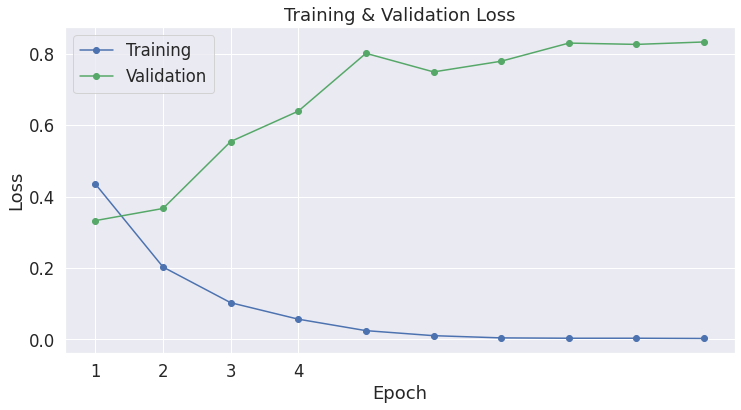

In [ ]:
df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.435388,0.332921,0.853860,0:07:02,0:00:40
2,0.202919,0.366902,0.866728,0:07:02,0:00:40
3,0.102943,0.554307,0.881434,0:07:02,0:00:40
4,0.056816,0.639482,0.886029,0:07:02,0:00:40
5,0.024721,0.801428,0.874081,0:07:02,0:00:40
6,0.010625,0.749363,0.892463,0:07:02,0:00:40
7,0.004402,0.779316,0.893382,0:07:02,0:00:40
8,0.003467,0.830107,0.885110,0:07:02,0:00:40
9,0.003446,0.826446,0.892463,0:07:02,0:00:40


In [ ]:
model.eval()

predictions , true_labels = [], []
 
for batch in validation_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [ ]:
real_label = []

In [ ]:
predicted_label = np.where(np.vstack(np.array(predictions))[:,1] >= np.vstack(np.array(predictions))[:,0], 1, 0) 

In [ ]:
for i in true_labels:
  for j in i: 
    real_label.append(j)

In [ ]:
print('accuracy',accuracy_score(real_label,predicted_label))
print('recall',recall_score(real_label,predicted_label))
print('precision',precision_score(real_label,predicted_label))
print('F-score',f1_score(real_label,predicted_label))

accuracy 0.8911627906976745
recall 0.8838951310861424
precision 0.8956356736242884
F-score 0.8897266729500471


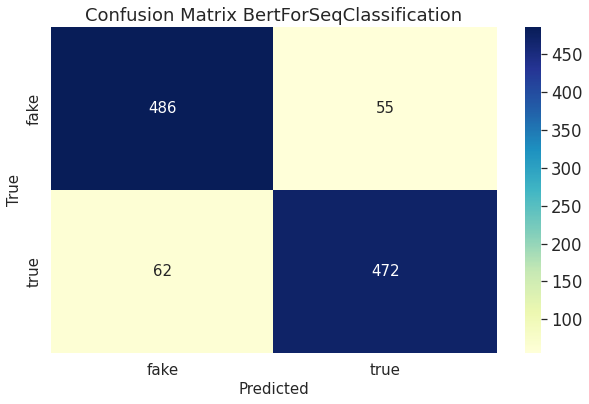

In [ ]:
conf_matrix(cm=confusion_matrix(real_label,predicted_label),title='BertForSeqClassification')

In [ ]:
#Error analysis
error_pred = []
error_real = []
error_text = []
for pred,real,index in zip(predicted_label,real_label,range(len(real_label))): 
  if pred != real:
    error_pred.append(pred)
    error_real.append(real)
    error_text.append(tokenizer.decode(val_dataset[index][0]))
error_df = pd.DataFrame({'text':error_text,'prediction':error_pred,'real':error_real})
error_df

,text,prediction,real
0,[CLS] francia expulsa cinco miembros familia b...,0,1
1,[CLS] prohiben entrar colegio dos ninos mallor...,0,1
2,[CLS] intentan asesinar principal asesor presi...,0,1
3,[CLS] macron decretado emergencia francia pari...,1,0
4,[CLS] ano celebrando todas precauciones posibl...,0,1
...,...,...,...
112,[CLS] ultimahora asesino alcala ataco victima ...,0,1
113,[CLS] adrenocromo droga elite oscura ligada tr...,1,0
114,[CLS] chorpresa santiago abascal tambien sale ...,1,0
115,[CLS] expulsan pleno congreso diputado vox lla...,0,1


In [ ]:
error_df['text'] = error_df['text'].str.replace('[CLS]','')
error_df['text'] = error_df['text'].str.replace('[PAD]','')


In [ ]:
error_df

,text,prediction,real
0,francia expulsa cinco miembros familia bosnia...,0,1
1,prohiben entrar colegio dos ninos mallorca ll...,0,1
2,intentan asesinar principal asesor presidente...,0,1
3,macron decretado emergencia francia paris men...,1,0
4,ano celebrando todas precauciones posibles de...,0,1
...,...,...,...
112,ultimahora asesino alcala ataco victima dia c...,0,1
113,adrenocromo droga elite oscura ligada trafico...,1,0
114,chorpresa santiago abascal tambien sale papel...,1,0
115,expulsan pleno congreso diputado vox llamar b...,0,1


In [ ]:
error_df.to_excel('BertForSeqClass.xlsx',index=False)